In [1]:
%load_ext autoreload
%autoreload 2

import wandb
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
from text3d2video.sd_feature_extraction import DiffusionFeatureExtractor

from text3d2video.diffusion import depth2img, depth2img_pipe
from text3d2video.rendering import normalize_depth_map, rasterize
from text3d2video.animation_artifact import AnimationArtifact

/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0")

anim_artifact = 'backflip:latest'

api = wandb.Api()
anim_artifact = api.artifact(f'romeu/diffusion-3D-features/{anim_artifact}')
anim_artifact = AnimationArtifact.from_wandb_artifact(anim_artifact)

mesh = anim_artifact.load_static_mesh(device)

R, T = look_at_view_transform(dist=2, azim=0, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact backflip:latest, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


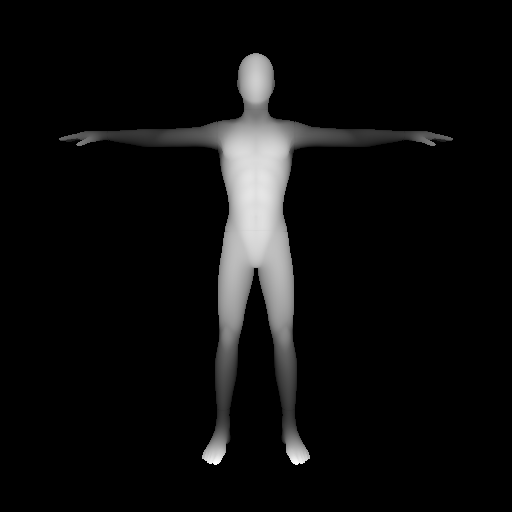

In [3]:
res = 512
fragments, depth_map = rasterize(cameras, mesh, res)
depth_map_normalized = normalize_depth_map(depth_map).to(device).unsqueeze(0)

depth_img = TF.to_pil_image(depth_map_normalized)
depth_img

In [4]:
pipe = depth2img_pipe(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facin

In [5]:
# setup feature extractor
extractor = DiffusionFeatureExtractor()
extractor.add_save_feature_hook('level_0', pipe.unet.up_blocks[0])
extractor.add_save_feature_hook('level_1', pipe.unet.up_blocks[1])
extractor.add_save_feature_hook('level_2', pipe.unet.up_blocks[2])

100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


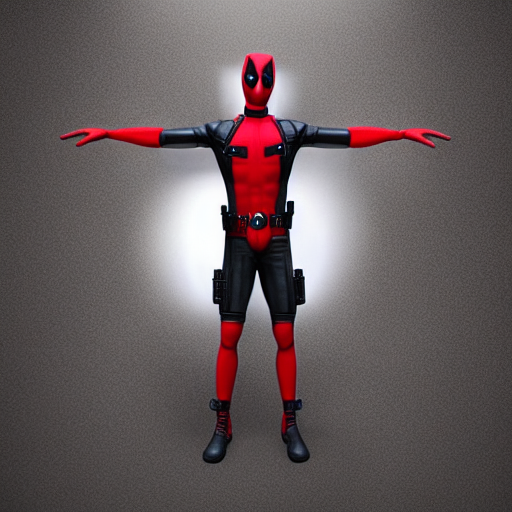

In [6]:
extractor.clear_features()
img_out = depth2img(pipe, ['Deadpool Dancing'], [depth_img])
img_out[0]

torch.Size([640, 64, 64])

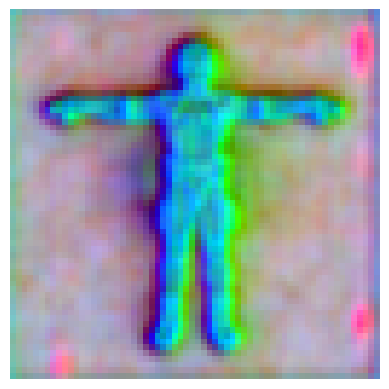

: 

In [8]:
# %% inspect features
from einops import rearrange
from text3d2video.visualization import RgbPcaUtil

feature_map = extractor.get_feature('level_2', timestep=20)[0]
feature_flat = rearrange(feature_map, 'c h w -> (h w) c')

pca = RgbPcaUtil(feature_flat.shape[1])
pca.fit(feature_flat)

feature_pca = pca.feature_map_to_rgb(feature_map)

plt.axis('off')
plt.imshow(feature_pca.permute(1, 2, 0))
feature_map.shape